# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from utils import *

sns.set()
warnings.filterwarnings("ignore")
SEED=0
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [4]:
# reduce memory size
azdias = reduce_mem_usage(azdias)
customers = reduce_mem_usage(customers)

Memory usage of dataframe is 2488.61 MB
Memory usage after optimization is: 542.43 MB
Decreased by 78.2%
Memory usage of dataframe is 539.55 MB
Memory usage after optimization is: 117.25 MB
Decreased by 78.3%


## 0.1 Values QA

We are provided with a file with the metadata about the columns values. The goal of this section is to make sure the values in the data are consistent with those provided. We will look at null and values outside the limits established.

#### Columns with Metadata

We are provided with a reference excel file with the metadata and description of the columns in the dataset. As a first approach, this will be our source of truth to address null values and outliers. Columns that do not appears in this metadata will be dropped.

In [5]:
# load metadata
values_metadata = load_metadata()
values_metadata.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [6]:
columns_with_metadata = values_metadata['Attribute'].unique().tolist()
columns_with_metadata_azdias = [x for x in azdias.columns if x in columns_with_metadata]
columns_with_metadata_customers = [x for x in customers.columns if x in columns_with_metadata]
print(f'There are {len(columns_with_metadata_azdias)} of {len(azdias.columns)} with metadata in azdias dataset')
print(f'There are {len(columns_with_metadata_customers)} of {len(customers.columns)} metadata in customers dataset')

There are 272 of 366 with metadata in azdias dataset
There are 272 of 369 metadata in customers dataset


In [7]:
# Select columns with metadata
azdias_clean = select_metadata_columns(azdias, columns_with_metadata)
customers_clean = select_metadata_columns(customers, columns_with_metadata)

#### Solve mixed data types
In Column 19 there are mixed data types. These columns contains some rows with values 'X' or 'XX' for which there is no registry they are valid values. I will convert these values to NaN and change the data type to float for the entire column.

In [8]:
# solve mixed datatypes
azdias_clean = fix_column_mixed_datatypes(azdias_clean)
customers_clean = fix_column_mixed_datatypes(customers_clean)                                                                   

#### Null Values

According to the metadata info, there are values that indicates unknown values for the column. These values will be replace by a proper NaN values to ease the handling of null values.

In [9]:
#check which values points to null values.
null_metadata = values_metadata[values_metadata['Meaning'].str.contains('unknown')]
null_metadata['Value'] = null_metadata['Value'].apply(lambda x: x.split(',') if isinstance(x, str) else [x])
null_metadata['Value'] = null_metadata['Value'].apply(lambda row: list(map(float, row)))
null_metadata.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,[-1.0],unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1.0, 0.0]",unknown
11,ALTER_HH,main age within the household,[0.0],unknown / no main age detectable
33,ANREDE_KZ,gender,"[-1.0, 0.0]",unknown
40,BALLRAUM,distance to next urban centre,[-1.0],unknown


In [10]:
# replace values with NaN
azdias_clean = replace_with_NaN(azdias_clean, null_metadata)
customers_clean = replace_with_NaN(customers_clean, null_metadata)

224 columns were affected
224 columns were affected


In [11]:
# save qa_files
if not os.path.exists('data'):
    os.makedirs('data')
    
azdias_clean.to_csv('data/azdias_qa.csv', index=False)
customers_clean.to_csv('data/customers_qa.csv', index=False)

## 0.2 Feature Engineering for Clustering

Feature Engineering for clustering is the next step. This will include the following:
 - Handle outliers
 - Check for additional variables and cardinality of categorical and date variables
 - Define criteria to remove rows and columns
 - Data Standarization

In [12]:
# Read if needed
# azdias_clean = pd.read_csv('data/qa_data/azdias_qa.csv')
# customers_clean = pd.read_csv('data/qa_data/customers_qa.csv')
# azdias_clean = reduce_mem_usage(azdias_clean)
# customers_clean = reduce_mem_usage(customers_clean)

#### Outliers

The attribute info file provide us with the range of valid values for each column, apart from the null values. Values outside this range will be defaulted to either the min or max value according to the metadata.

In [15]:
values_boundaries = values_metadata.query('Meaning != "unknown"')\
                    .groupby('Attribute')['Value']\
                    .agg([np.min, np.max])\
                    .reset_index()

values_boundaries['amin'] = pd.to_numeric(values_boundaries['amin'], errors='coerce')
values_boundaries['amax'] = pd.to_numeric(values_boundaries['amax'], errors='coerce')
values_boundaries.dropna(inplace=True)


azdias_clean = cap_outliers_values(azdias_clean, values_boundaries)
customers_clean = cap_outliers_values(customers_clean, values_boundaries)

263 columns were affected
263 columns were affected


#### Categorical Variables

There are 2 columns which types are not numeric. As a first approach, a column will be dropped if it has more than 10 unique values, if it has less, One-Hot Encoding will be applied to it. A high cardinality variable is going to increase the dimension space too much.

Given the unique values in the following cell, OST_WEST_KZ, a categorical type with two unique values, and EIGEFUEGT_AM which is the date type are selected to be used in the first iteration.

In [16]:
# check nunique value
cat_date = azdias_clean.select_dtypes(include='category')
for var in cat_date.columns:
    unique_val = cat_date[var].nunique()
    print(var, 'has', unique_val, 'unique values')
    if unique_val <= 10:
        print(cat_date[var].unique())

CAMEO_DEU_2015 has 45 unique values
OST_WEST_KZ has 2 unique values
[NaN, 'W', 'O']
Categories (2, object): ['W', 'O']


In [17]:
# onehot encoding for one, drop the other one.
azdias_clean = cat_type_fe(azdias_clean)
customers_clean = cat_type_fe(customers_clean)

#### Remove Null Values

In the first cell, we take a look at the level of null values in the columns. The plot shows the percentage of columns below a % threshold of null values. About 95% of columns has a 20% or less of null values. The other 5% will be removed. 

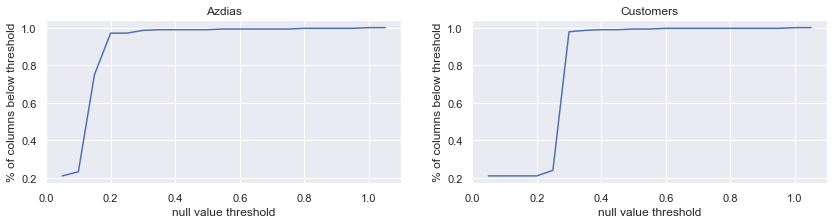

In [18]:
#column wise
thresholds = np.arange(0.05,1.1,0.05)
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,3))
sns.lineplot(x=thresholds, y = generate_null_list(azdias_clean, thresholds), ax=ax1)
ax1.set_title('Azdias')
ax1.set_xlabel('null value threshold')
ax1.set_ylabel('% of columns below threshold')


sns.lineplot(x=thresholds, y = generate_null_list(customers_clean, thresholds), ax=ax2)
ax2.set_title('Customers')
ax2.set_xlabel('null value threshold')
ax2.set_ylabel('% of columns below threshold')

plt.show()

In this cell, we take a row wise approach after applying the approach of removing the columns with 20% or more null values. The plot shows the % of rows with null values below the threshold. In this case, the 87% of rows have less than 20% of null values. Given the big dataset, we can be confident in dropping the 13%.

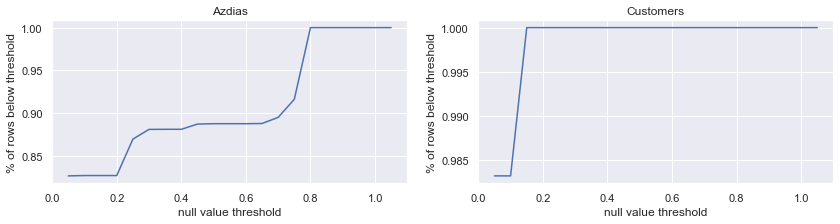

In [19]:
#row wise
thresholds = np.arange(0.05,1.1,0.05)
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,3))
sns.lineplot(x=thresholds, y = generate_null_row_list(azdias_clean, thresholds, 0.2), ax=ax1)
ax1.set_title('Azdias')
ax1.set_xlabel('null value threshold')
ax1.set_ylabel('% of rows below threshold')


sns.lineplot(x=thresholds, y = generate_null_row_list(customers_clean, thresholds, 0.2), ax=ax2)
ax2.set_title('Customers')
ax2.set_xlabel('null value threshold')
ax2.set_ylabel('% of rows below threshold')

plt.show()

In [20]:
azdias_clean = remove_null(azdias_clean, 0.3,0.2)
customers_clean = remove_null(customers_clean, 0.3,0.2)


### Impute null values
There are still columns and rows will null values. To address this, the null values will be replaced by the mode of the columns. The values are more of a discrete type rather than a continuous, so it makes more sense to replace null values with the one that appears the most.

In [21]:
# replace with mode
azdias_clean = mode_imputation(azdias_clean)
customers_clean = mode_imputation(customers_clean)

#### Clean function

In this section we are going to test a function that groups all previous steps. This will give us a pipeline from raw dataset to a clean dataset ready for modelling purposes.

In [49]:
values_metadata = load_metadata()

azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
azdias = reduce_mem_usage(azdias)
azdias_clean = clean_datasets(df = azdias, metadata=values_metadata, remove_null_values=True, column_limit=0.3, row_limit=0.3)

Memory usage of dataframe is 2488.61 MB
Memory usage after optimization is: 542.43 MB
Decreased by 78.2%
Selecting Columns with metadata
Fixing mix data types
Replace values for NaN
224 columns were affected
Capping Outliers
263 columns were affected
Feature Eng for categorical variables
Removing rows and columns with more than 20% null values
Impute Null values with Mode
Pipeline Finished


In [50]:
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers = reduce_mem_usage(customers)
customers_clean = clean_datasets(df = customers, metadata=values_metadata, remove_null_values=True, column_limit=0.35, row_limit=0.3)

Memory usage of dataframe is 539.55 MB
Memory usage after optimization is: 117.25 MB
Decreased by 78.3%
Selecting Columns with metadata
Fixing mix data types
Replace values for NaN
224 columns were affected
Capping Outliers
263 columns were affected
Feature Eng for categorical variables
Removing rows and columns with more than 20% null values
Impute Null values with Mode
Pipeline Finished


In [51]:
final_cols = [var for var in customers_clean.columns if var in azdias_clean.columns]
customers_clean = customers_clean[final_cols]

#### Standarization

The final step is to scale the data using the standard method. Many ML algorithms (like PCA and KMeans) works better if data is scaled properly because they employ some form of distance in their loss function.

In [52]:
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_clean), columns=azdias_clean.columns)
customers_scaled = pd.DataFrame(scaler.transform(customers_clean), columns=customers_clean.columns)

In [ ]:
# save final data
azdias_scaled.to_csv('data/azdias_scaled.csv', index=False)
customers_scaled.to_csv('data/customers_scaled.csv', index=False)

In [53]:
azdias, customers = None, None

### 1. PCA AND CLUSTERING

In this section, the modelling for clustering is done. The first step is to perform a PCA analysis. The current dimensional space is around 270 features, quite high for algorithms like KMeans. A PCA transformation has the goal to reduce this feature space while retaining the mayority of variance.

### 1.1 PCA

First, a PCA transformation without setting a number of components will help us to see how many of them we want to inlucde in our analysis. In this first approach, we aim to retain around 80% of the variance. 

After applying the algorithm, it says that we require 85 components.

In [54]:
pca = PCA(random_state=SEED)
pca.fit_transform(azdias_scaled)

array([[-1.59422417e+00,  5.67374495e+00,  1.69335618e+00, ...,
        -7.53006307e-02,  5.07783577e-15,  4.56022033e-14],
       [ 6.26242952e-01,  2.93436964e+00, -2.58133642e+00, ...,
        -1.75510430e-02, -1.36344150e-15, -8.17497792e-15],
       [ 3.92036954e+00,  1.03019775e+00, -5.66689445e+00, ...,
         1.95482901e-01,  2.06080821e-15,  2.21065380e-14],
       ...,
       [ 2.37377519e+00,  2.06451102e-01,  1.69351045e-01, ...,
         1.22386671e-01, -1.29927667e-16,  5.97712951e-16],
       [-7.59479460e+00, -2.61561516e+00,  2.68345756e+00, ...,
         3.50107170e-02,  2.02412769e-16,  4.15517191e-16],
       [-4.41422657e-01,  4.72133978e-01, -4.57023282e+00, ...,
         2.27307183e-03,  1.31335915e-16,  2.97227595e-15]])

To achieve 80% of variance are required 85 components


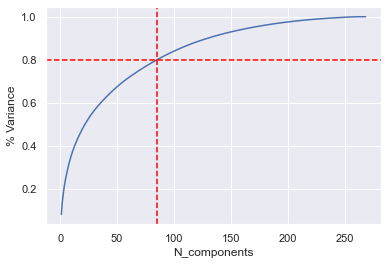

In [55]:
desired_variance=0.8
cum_variance = np.cumsum(pca.explained_variance_ratio_)
required_components = np.where(cum_variance >= desired_variance)[0][0] + 1
print(f'To achieve {desired_variance:.0%} of variance are required {required_components} components')
sns.lineplot(x=np.arange(1,pca.n_components_+1), y=cum_variance)
plt.axhline(desired_variance, linestyle='dashed', color='red')
plt.axvline(required_components, linestyle='dashed', color='red')
plt.xlabel('N_components')
plt.ylabel('% Variance')
plt.show()

In [56]:
pca = PCA(n_components=required_components, random_state=SEED)
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.transform(customers_scaled)

### Explain components
Well try to explain what variables influences some of the components from the PCA

In [57]:
def explain_component(df, pca, component, top_weights=5, print_description=False):
    weights = pd.DataFrame(pca.components_[component], index=azdias_scaled.columns, columns=['weights'])\
                .sort_values(by='weights', ascending=True)

    top_n_weights = pd.concat([weights.iloc[:top_weights], weights.iloc[-top_weights:]])

    sns.barplot(x=top_n_weights['weights'], y = top_n_weights.index)
    plt.title(f'PCA Composition for component {component}')
    plt.show()
    
    if print_description:
        atributos_top_n = top_n_weights.index.tolist()
        print(values_metadata\
            .loc[lambda row: row['Attribute'].isin(atributos_top_n),:]\
            .query('Meaning != "unknown"')\
            .groupby(['Attribute', 'Description'])['Value']\
            .agg([np.min, np.max])\
            .reset_index()
            .drop(columns=['amin', 'amax'])
             )

#### Component 0

The output from the function indicates that this component has relation with the socialeconomic status of a user in question.

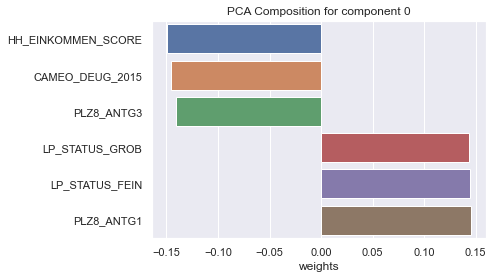

            Attribute                               Description
0     CAMEO_DEUG_2015    CAMEO classification 2015 - Uppergroup
1  HH_EINKOMMEN_SCORE           estimated household net income 
2      LP_STATUS_FEIN                        social status fine
3      LP_STATUS_GROB                       social status rough
4          PLZ8_ANTG1   number of 1-2 family houses in the PLZ8
5          PLZ8_ANTG3  number of 6-10 family houses in the PLZ8


In [58]:
explain_component(azdias_scaled, pca, 0, 3, True)

#### Component 1

The output from the function indicates that this component has relation with the car ownership from the user in question.

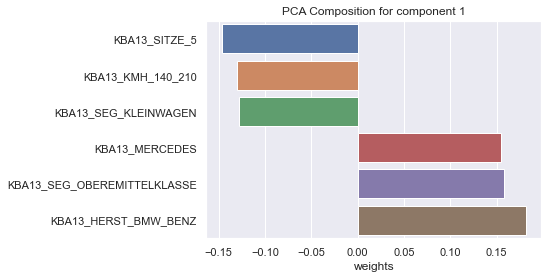

                     Attribute  \
0         KBA13_HERST_BMW_BENZ   
1            KBA13_KMH_140_210   
2               KBA13_MERCEDES   
3         KBA13_SEG_KLEINWAGEN   
4  KBA13_SEG_OBEREMITTELKLASSE   
5                KBA13_SITZE_5   

                                         Description  
0       share of BMW & Mercedes Benz within the PLZ8  
1  share of cars with max speed between 140 and 2...  
2                  share of MERCEDES within the PLZ8  
3  share of small and very small cars (Ford Fiest...  
4  share of upper middle class cars and upper cla...  
5            number of cars with 5 seats in the PLZ8  


In [59]:
explain_component(azdias_scaled, pca, 1,3,True)

#### Component 2

The output from the function indicates that this component has relation with the user online payment history

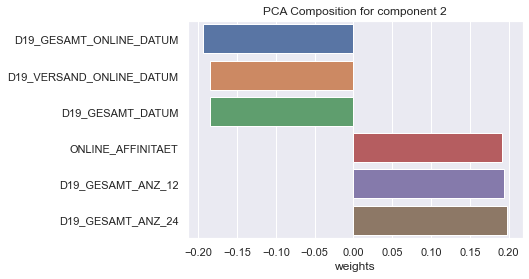

                  Attribute                                        Description
0         D19_GESAMT_ANZ_12  transaction activity TOTAL POOL in the last 12...
1         D19_GESAMT_ANZ_24  transaction activity TOTAL POOL in the last 24...
2          D19_GESAMT_DATUM  actuality of the last transaction with the com...
3   D19_GESAMT_ONLINE_DATUM  actuality of the last transaction with the com...
4  D19_VERSAND_ONLINE_DATUM  actuality of the last transaction for the segm...
5         ONLINE_AFFINITAET                                    online affinity


In [60]:
explain_component(azdias_scaled, pca, 2,3,True)

### K-Means

To select the number of clusters, we will apply the elbow method. we will fit various model with a range of clusters and we will select the cluster for which the score bends, indicating a turning point. From the chart above, we will select 7 clusters.

In [61]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    scores = []
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))
    for n in range(K_start, K_end+1, step):
#         print("\nTraining for n_clusters: ", n)
        start = time.time()
        kmeans = MiniBatchKMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
#         print("Done! Score: ", scores[-1])
#         print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

Performing K-Means clustering
Given range min:2, max:20, step:1


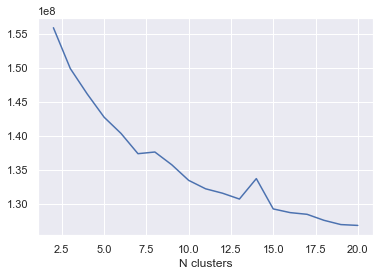

In [62]:
import time

scores, range_ = get_Kmeans_scores(azdias_pca, 2, 20, 1)
sns.lineplot(x=range_, y=scores)
plt.xlabel('N clusters')
plt.show()

In [63]:
# fit a model with 7 clusters
kmeans= MiniBatchKMeans(7,random_state=SEED)
kmeans.fit(azdias_pca)

azdias_clusters = kmeans.predict(azdias_pca)
customer_clusters = kmeans.predict(customers_pca)

### Cluster exploration

#### Cluster distribution

From the plot below, it seems there is likelihood for users in the clustres 2,3 and 6 to be Customers of Arvato while users from the customers 0 and 1 are not. 

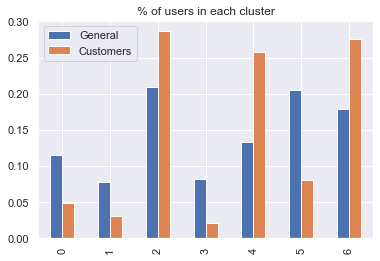

In [64]:
cluster_distribution = pd.concat([
                        pd.Series(azdias_clusters).value_counts(normalize=True).to_frame().sort_index(),
                        pd.Series(customer_clusters).value_counts(normalize=True).to_frame().sort_index(),
                    ],
                    axis=1
                    )
cluster_distribution.columns=['General', 'Customers']

cluster_distribution.plot(kind='bar')
plt.title('% of users in each cluster')
plt.show()

### Cluster interpretability

To understand each cluster, we'll take a look at the variables that forms the first 3 components from the PCA, which accounts for about 20% of the variance. The focus will be on clusteres 2,4 and 6 from where the majority of customers are from.

In [65]:
cols_to_select = [
    'CAMEO_DEUG_2015',
    'HH_EINKOMMEN_SCORE',
    'LP_STATUS_FEIN',
    'LP_STATUS_GROB',
    'PLZ8_ANTG1',
    'PLZ8_ANTG3',
    'KBA13_HERST_BMW_BENZ',
    'KBA13_KMH_140_210',
    'KBA13_MERCEDES',
    'KBA13_SEG_KLEINWAGEN',
    'KBA13_SEG_OBEREMITTELKLASSE',
    'KBA13_SITZE_5',
    'D19_GESAMT_ANZ_12',
    'D19_GESAMT_ANZ_24',
    'D19_GESAMT_DATUM',
    'D19_GESAMT_ONLINE_DATUM',
    'D19_VERSAND_ONLINE_DATUM',
    'ONLINE_AFFINITAET'
    
]

cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=azdias_scaled.columns)\
.loc[:,cols_to_select]
cluster_specs

,CAMEO_DEUG_2015,HH_EINKOMMEN_SCORE,LP_STATUS_FEIN,LP_STATUS_GROB,PLZ8_ANTG1,PLZ8_ANTG3,KBA13_HERST_BMW_BENZ,KBA13_KMH_140_210,KBA13_MERCEDES,KBA13_SEG_KLEINWAGEN,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SITZE_5,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_ONLINE_DATUM,D19_VERSAND_ONLINE_DATUM,ONLINE_AFFINITAET
0,7.944148,5.496592,1.857459,1.252179,1.056241,2.788293,3.569380,2.654319,3.380674,2.785102,3.625041,2.434790,0.549792,0.911758,7.632898,8.108385,8.351885,2.406346
1,4.670749,4.047415,6.521393,3.080798,2.655994,0.930389,1.804876,3.316948,1.889252,3.857626,1.888584,4.487002,1.025683,1.567274,6.368031,7.113980,7.383341,2.876338
2,4.144639,3.676613,7.087760,3.409899,2.975947,0.855304,3.112408,3.004206,3.151618,2.858780,3.126575,2.679865,0.230675,0.553640,8.125237,8.902457,9.154192,2.285215
3,7.625917,5.621167,2.073273,1.282835,1.151690,2.628759,1.842536,3.441021,1.849410,3.671949,1.962675,4.425545,0.549548,0.915581,7.581318,8.148202,8.367385,2.269978
4,4.524410,3.687482,5.126627,2.718708,2.334696,1.600713,4.265250,1.932117,4.092466,2.151632,4.021287,2.082601,0.599679,1.023889,7.274228,7.980227,8.221351,2.576513
5,6.949844,5.571194,2.278513,1.400215,1.963081,1.960442,3.226877,2.960868,3.266923,3.084486,3.277145,2.658724,0.256765,0.511489,8.389751,8.941152,9.130640,1.965124
6,4.269285,3.461821,6.890026,3.326200,2.753162,1.128523,3.265775,2.891093,3.270052,2.864418,3.223839,2.638840,2.818904,3.896704,2.376172,3.141947,3.672753,4.660419


Cluster 0, 4 and 5 seems to be formed from users between upper class and consupmtion oriented middle class with high income given their lower median score in both CAMEO_DEUG_2015 and HH_EINKOMMEN_SCORE variables.

The high values in the LP_STATUS variables indicates these users are workers with rental properties in their names, either recently bought or not.

The high value in the PLZ8_ANTG1 and the low value in the PLZ8_ANTG3 suggests these users may be young worker that are either single or have just started living in couple. There's a big share of familiy houses with only 1-2 numbers.

The distribution of variables KBA* that characterizes cars indicates that the uses from the cluster 4 like to have sedan luxury cars, given their high share of mercedes, low share with cars with 5 or more seats and car with a max-size speed between 140-210. The users from the clusters 0 and 5 seems to be more conservative in this regards. Maybe this indicates these type of users already have children while the users from the clusters 5 not. 

Finally, the last set of variables indicates the users from the cluster 3 have way more affinity for online transactions and activities than the others clusters.

In conlusion, I'd say the customer persona for the company are high-paid young worker. They're either single, with interest in luxury or in couple or soon to be fathers with more conservative interests. Between these users, there are people who have great affinity for online transactions.

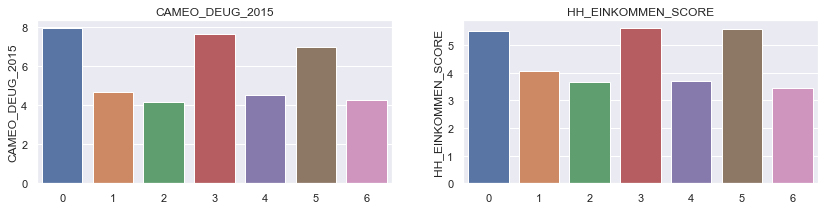

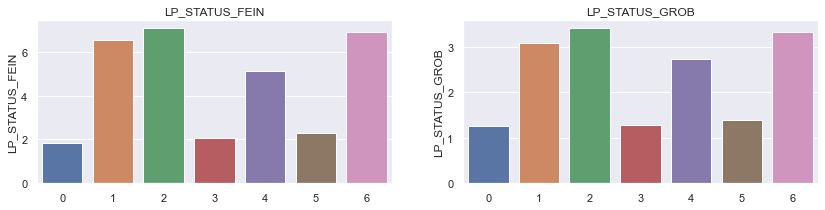

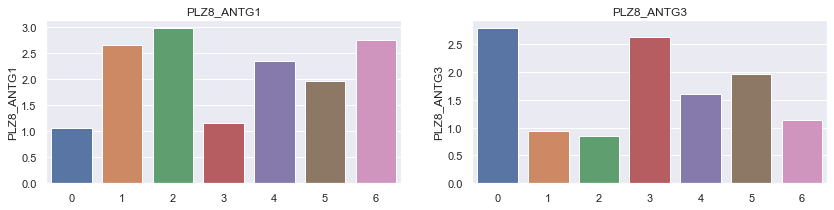

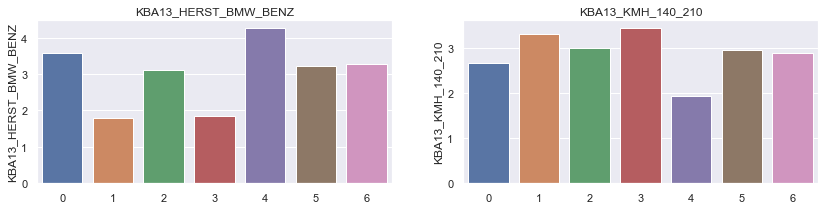

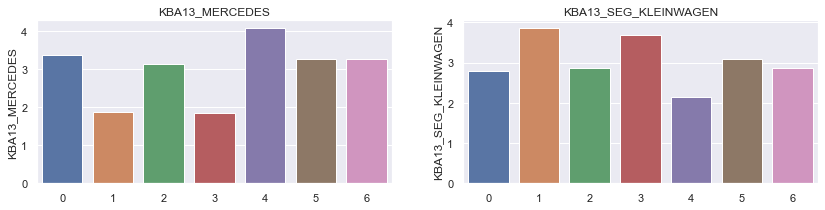

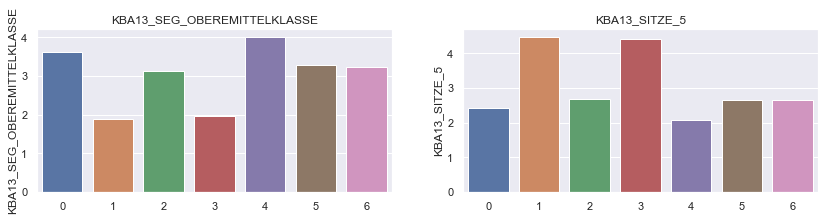

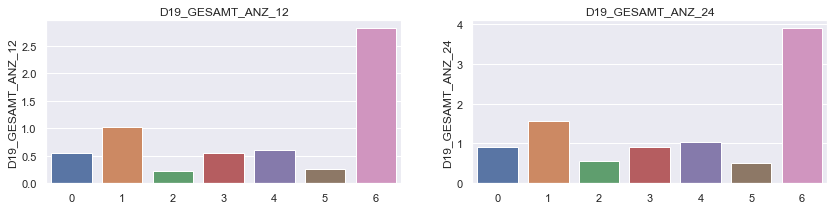

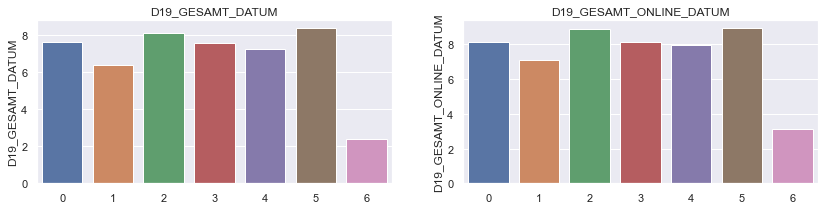

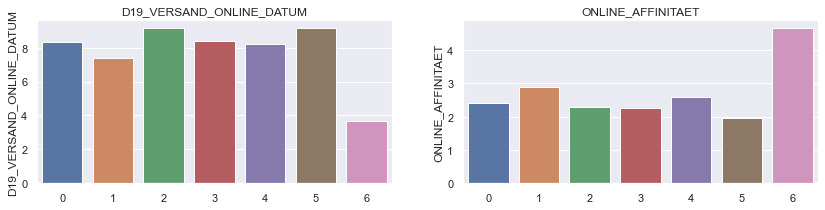

In [66]:
it = iter(cluster_specs.columns)
for i in it:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,3))
    var1 = i 
    sns.barplot(x=cluster_specs.index, y=cluster_specs[var1], ax=ax1)
    ax1.set_title(var1)
    try:
        var2 = next(it)
        sns.barplot(x=cluster_specs.index, y=cluster_specs[var2], ax=ax2)
        ax2.set_title(var2)
    except:
        pass

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [40]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
values_metadata = load_metadata()

In [41]:
mailout_train_clean = clean_datasets(df = mailout_train, metadata=values_metadata, column_limit=0.3, row_limit=0.3)
labels = mailout_train.loc[mailout_train_clean.index,'RESPONSE']

Selecting Columns with metadata
Fixing mix data types
Replace values for NaN
224 columns were affected
Capping Outliers
263 columns were affected
Feature Eng for categorical variables
Removing rows and columns with more than 20% null values
Impute Null values with Mode
Pipeline Finished


#### Baseline
The baseline model will be a Logistic Regression without scaling the data. This will be the easiest approach. 
To compare differents models, the ROC score will be used. The Data is highly imbalanced, one class represent about 98% of the labels.

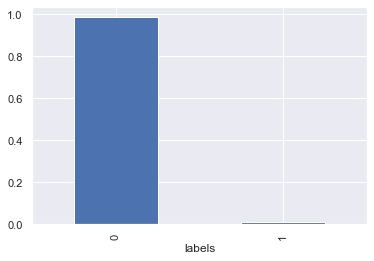

In [43]:
#imbalaced class
labels.value_counts(normalize=True).plot(kind='bar')
plt.xlabel('labels')
plt.show()

#### Baseline model

In [44]:
# scale the data
scaler = StandardScaler()
mailout_train_scaled = pd.DataFrame(scaler.fit_transform(mailout_train_clean), columns = mailout_train_clean.columns)
X_train, X_val, y_train, y_val = train_test_split(mailout_train_scaled, labels, stratify=labels, test_size=0.2, random_state=SEED)
lr = LogisticRegression(random_state=SEED, max_iter=10000)
lr.fit(X_train, y_train)
yhat = lr.predict_proba(X_val)[:,1]
print("Baseline AUROC - ", roc_auc_score(y_val, yhat))

Baseline AUROC -  0.6457432357161503


#### Train multiple models

In this section we are going to train multiple models to see which one has a better performance than the baseline

In [45]:
from lightgbm import LGBMClassifier

def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed

models = [("LogisticRegression", LogisticRegression(random_state=SEED, max_iter=10000)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
          ('KNeighbors', KNeighborsClassifier()),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

In [46]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    print(name)
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

    
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

LogisticRegression
RandomForestClassifier
GradientBoostingClassifier
AdaBoostClassifier
KNeighbors
XGBClassifier
[18:50:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.645743,1.541199
1,RandomForestClassifier,0.499505,7.058569
2,GradientBoostingClassifier,0.663263,32.320134
3,AdaBoostClassifier,0.623466,8.261115
4,KNeighbors,0.514606,6.676594
5,XGBClassifier,0.597926,3.18606


The best performant model was the GradientBoostingClassifier followed closely by LogisticRegression. They're chosen to perform some HyperParameter tuning

### Tuning

After selecting a model, we are going to perform a hyperparameter to improve its performance.

In [47]:
#Logistic Regression
param_grid = {"C": [-10,-5,-2,-1,-0,1,5,10,20,100],
              "penalty": ['l1', 'l2'],
              }

lr_grid = GridSearchCV(estimator = LogisticRegression(random_state=SEED, max_iter=10000), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=-1)

lr_grid.fit(X_train, y_train)

best_lr = lr_grid.best_estimator_

print("Best Score: ", lr_grid.best_score_)
print("Best Params: ", lr_grid.best_params_)

yhat_val = best_lr.predict_proba(X_val)[:,1]
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, yhat_val)))

Best Score:  0.5935127570087817
Best Params:  {'C': 1, 'penalty': 'l2'}
ROC score on validation data: 0.6457


In [48]:
# GradientBoosting
param_grid = {'max_depth': [3,4,5],
             'loss':['deviance', 'exponential'],
             'n_estimators': [100, 150, 200]}

gb_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 3, n_jobs = -1, verbose=2)

gb_grid.fit(X_train, y_train)

best_gb = gb_grid.best_estimator_

print("Best Score: ", gb_grid.best_score_)
print("Best Params: ", gb_grid.best_params_)

yhat_val = best_gb.predict_proba(X_val)[:,1]
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, yhat_val)))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Score:  0.6256816801537389
Best Params:  {'loss': 'exponential', 'max_depth': 4, 'n_estimators': 200}
ROC score on validation data: 0.6343


Tuning did not provide any performance increase for the LogisicRegression Model but it did for the GradientBoostingClassifier which reach 67% of ROC Score after tuning.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test_clean = clean_datasets(mailout_test, values_metadata, False)
mailout_test_clean = scaler.transform(mailout_test_clean[X_train.columns.tolist()])

In [ ]:
best_gb = GradientBoostingClassifier(random_state=SEED)
best_gb.fit(X_train, y_train)
yhat = pd.DataFrame(best_gb.predict_proba(mailout_test_clean)[:,1], index=mailout_test['LNR'], columns=['RESPONSE'])
yhat.head()

In [ ]:
yhat.to_csv("submission.csv")